In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2  
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Define the dataset directory
dataset_path = "C:\\Users\\ASUS\\Leaf Disease\\Classes for Disease"

# Initialize a list to store the data
data = []

# Loop through each class folder and create the image dataframe
for label in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, label)
    if os.path.isdir(class_folder):  # Ensure it's a folder
        for image_file in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_file)
            image = cv2.imread(image_path)  # Load image
            image = cv2.resize(image, (224, 224))  # Resize image to 224x224
            
            # Normalize the image pixels to range [0, 1]
            image = image / 255.0  # Dividing by 255 to normalize
            
            data.append((image, label))  # Append (image, label)

# Create a DataFrame from the list
df = pd.DataFrame(data, columns=['image', 'label'])

# Preview the DataFrame
print(df.head())
print(f"Total images: {len(df)}")

                                               image     label
0  [[[0.6980392156862745, 0.4980392156862745, 0.5...  Bacteria
1  [[[0.6941176470588235, 0.5294117647058824, 0.4...  Bacteria
2  [[[0.7254901960784313, 0.5843137254901961, 0.5...  Bacteria
3  [[[0.6862745098039216, 0.6196078431372549, 0.6...  Bacteria
4  [[[0.17254901960784313, 0.08627450980392157, 0...  Bacteria
Total images: 239


In [3]:
from sklearn.utils import shuffle
df = shuffle(df, random_state=42)

# Reset the index after shuffling
df.reset_index(drop=True, inplace=True)

# Preview the shuffled DataFrame
print(df.head())


                                               image      label
0  [[[0.6509803921568628, 0.4823529411764706, 0.4...   Bacteria
1  [[[0.7215686274509804, 0.5803921568627451, 0.5...   Bacteria
2  [[[0.6980392156862745, 0.596078431372549, 0.61...      Fungi
3  [[[0.5450980392156862, 0.5294117647058824, 0.5...  Nematodes
4  [[[0.4666666666666667, 0.49019607843137253, 0....  Nematodes


In [4]:
labels = df['label'].unique()
print("Unique labels:", labels)

# Step 2: Create an empty dictionary for label-to-index mapping
label_map = {}
index = 0

# Using a for loop to manually map labels to indices
for label in labels:
    label_map[label] = index
    index += 1

print("Label to Index Mapping:", label_map)

# Step 3: Update the 'label' column using a for loop
for i in range(len(df)):
    df.loc[i, 'label'] = label_map[df.loc[i, 'label']]

print("Updated DataFrame:\n", df)

Unique labels: ['Bacteria' 'Fungi' 'Nematodes' 'Normal' 'Virus']
Label to Index Mapping: {'Bacteria': 0, 'Fungi': 1, 'Nematodes': 2, 'Normal': 3, 'Virus': 4}
Updated DataFrame:
                                                  image label
0    [[[0.6509803921568628, 0.4823529411764706, 0.4...     0
1    [[[0.7215686274509804, 0.5803921568627451, 0.5...     0
2    [[[0.6980392156862745, 0.596078431372549, 0.61...     1
3    [[[0.5450980392156862, 0.5294117647058824, 0.5...     2
4    [[[0.4666666666666667, 0.49019607843137253, 0....     2
..                                                 ...   ...
234  [[[0.7058823529411765, 0.7176470588235294, 0.7...     2
235  [[[0.7294117647058823, 0.5411764705882353, 0.5...     0
236  [[[0.5529411764705883, 0.5372549019607843, 0.5...     1
237  [[[0.3058823529411765, 0.23921568627450981, 0....     3
238  [[[0.4549019607843137, 0.4549019607843137, 0.5...     2

[239 rows x 2 columns]


In [5]:
# Convert the images and labels into numpy arrays
X = np.array(df['image'].tolist())  # Image data
y = np.array(df['label'].tolist())  # Label data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the data generator on your training data
datagen.fit(X_train)





In [48]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

mobile_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu',kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(label_map), activation='softmax')
])

mobile_model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mobile_model.fit(datagen.flow(X_train, y_train, batch_size=32),
                 
                 epochs=30,
                 validation_data=(X_test, y_test))


Epoch 1/30


C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.2214 - loss: 3.7705 - val_accuracy: 0.2292 - val_loss: 3.1453
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 758ms/step - accuracy: 0.2639 - loss: 3.2082 - val_accuracy: 0.2500 - val_loss: 2.9530
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 757ms/step - accuracy: 0.2844 - loss: 3.0308 - val_accuracy: 0.2917 - val_loss: 2.7830
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 790ms/step - accuracy: 0.4220 - loss: 2.8789 - val_accuracy: 0.3542 - val_loss: 2.6303
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 764ms/step - accuracy: 0.3684 - loss: 2.8341 - val_accuracy: 0.3958 - val_loss: 2.4846
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 774ms/step - accuracy: 0.4633 - loss: 2.5672 - val_accuracy: 0.4583 - val_loss: 2.3668
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 760ms/step - accuracy: 0.5526 - loss: 2.5024 - val_accuracy: 0.5000 - val_loss: 2.2665
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 758ms/step - accuracy: 0.5283 - loss: 2.4530 - val_accuracy: 0.6250 - val_loss: 2.1782
Epoch

In [49]:
mobile_model.evaluate(X_train, y_train)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 710ms/step - accuracy: 0.9513 - loss: 1.3741


[1.356503963470459, 0.963350772857666]

In [50]:
mobile_model.evaluate(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 377ms/step - accuracy: 0.9236 - loss: 1.4898


[1.476226806640625, 0.9166666865348816]

In [51]:
# Make predictions on the test set
predictions = mobile_model.predict(X_test)

# Get the predicted class indices
predicted_classes = np.argmax(predictions, axis=-1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


In [52]:
from sklearn.metrics import accuracy_score

# Assuming y_test contains the true class indices
accuracy = accuracy_score(y_test, predicted_classes)
print(f"Test accuracy: {accuracy * 100:.2f}%")


Test accuracy: 91.67%


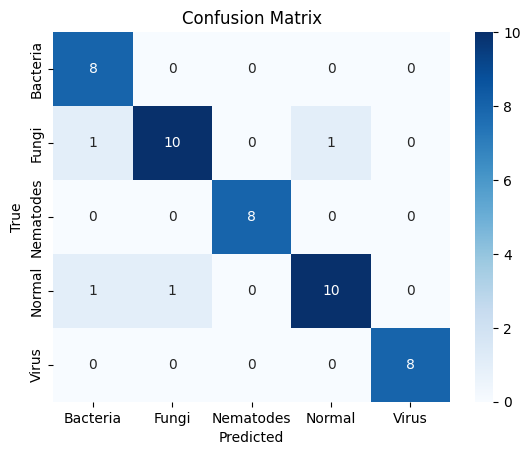

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)

# Plot the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [54]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_test, predicted_classes, target_names=labels)
print(report)


              precision    recall  f1-score   support

    Bacteria       0.80      1.00      0.89         8
       Fungi       0.91      0.83      0.87        12
   Nematodes       1.00      1.00      1.00         8
      Normal       0.91      0.83      0.87        12
       Virus       1.00      1.00      1.00         8

    accuracy                           0.92        48
   macro avg       0.92      0.93      0.93        48
weighted avg       0.92      0.92      0.92        48



In [55]:
label_map

{'Bacteria': 0, 'Fungi': 1, 'Nematodes': 2, 'Normal': 3, 'Virus': 4}

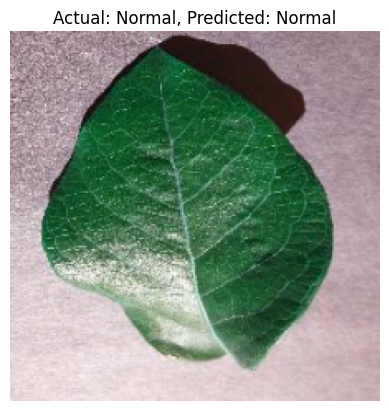

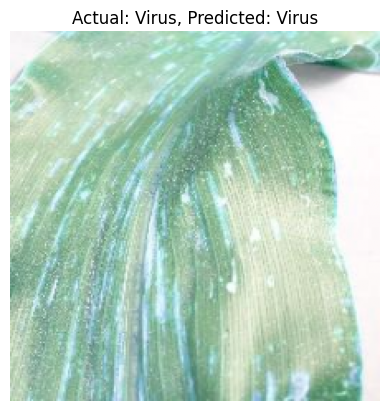

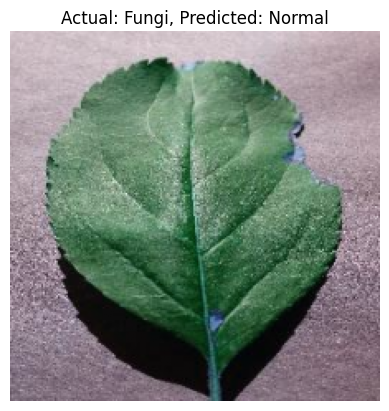

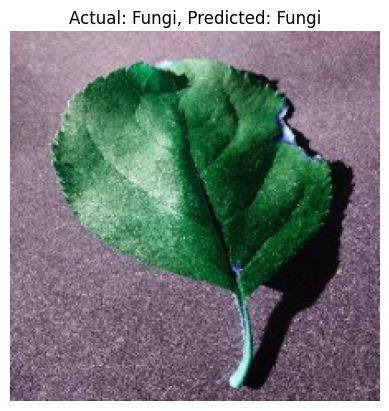

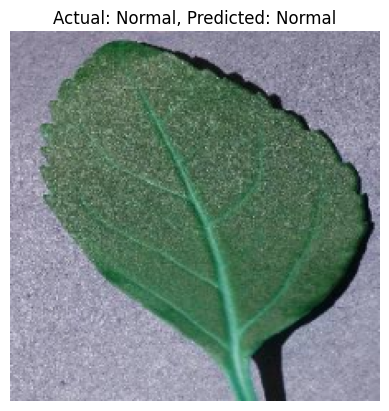

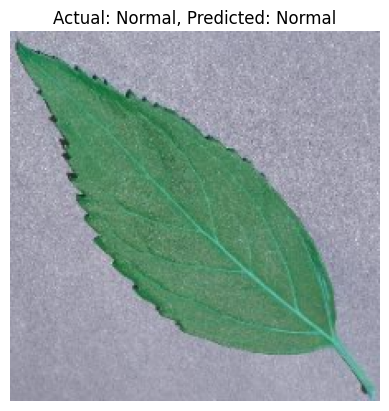

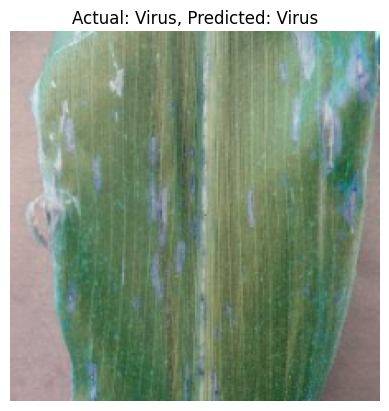

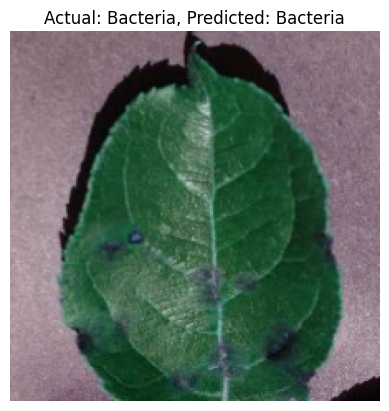

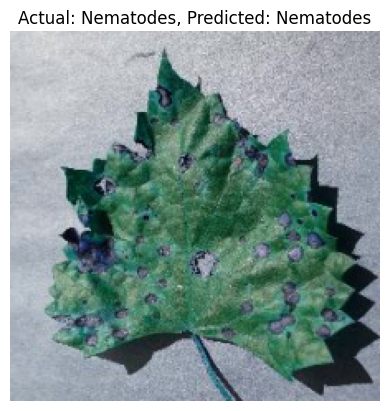

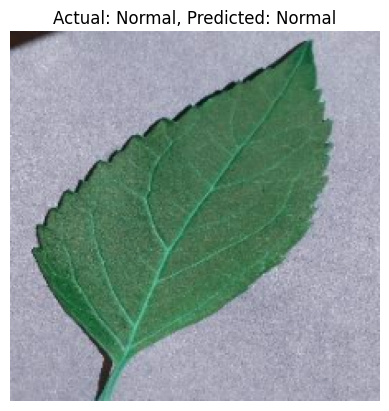

Image 1: Actual: Normal, Predicted: Normal
Image 2: Actual: Virus, Predicted: Virus
Image 3: Actual: Fungi, Predicted: Normal
Image 4: Actual: Fungi, Predicted: Fungi
Image 5: Actual: Normal, Predicted: Normal
Image 6: Actual: Normal, Predicted: Normal
Image 7: Actual: Virus, Predicted: Virus
Image 8: Actual: Bacteria, Predicted: Bacteria
Image 9: Actual: Nematodes, Predicted: Nematodes
Image 10: Actual: Normal, Predicted: Normal


In [56]:
class_names = {0: 'Bacteria', 1: 'Fungi', 2: 'Nematodes', 3: 'Normal', 4: 'Virus'}
predicted_class_names = [class_names[idx] for idx in predicted_classes]


# Convert actual labels to class names for comparison
actual_class_names = [class_names[idx] for idx in y_test]

# Step 5: Display a few predictions
for i in range(10):  # Show the first 10 predictions
    plt.imshow(X_test[i])  # Display the image
    plt.title(f"Actual: {actual_class_names[i]}, Predicted: {predicted_class_names[i]}")
    plt.axis('off')  # Hide axis
    plt.show()

for i in range(10):  # Show the first 10 predictions in text form
    print(f"Image {i+1}: Actual: {actual_class_names[i]}, Predicted: {predicted_class_names[i]}")